In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

import random

import gc

%matplotlib inline

# view_data = 用户观看主播的数据

# anchor_list = 主播被观看的次数的数据

In [5]:
view_data = pd.read_csv("../viewData/view_data.csv")

In [6]:
view_data

,uid,live_uid
0,159876050,724698357
1,735586379,724698357
2,735586379,724698357
3,108339673,724698357
4,108339673,724698357
...,...,...
18928319,722748450,14237047
18928320,99570557,733632108
18928321,134628369,733632108
18928322,735200625,735587024


In [7]:
anchor_list = pd.read_csv("../viewData/anchor_list.csv")

In [8]:
anchor_list

,live_uid,count
0,730183576,558593
1,16673072,123029
2,4994793,95888
3,21678553,94230
4,735415548,90641
...,...,...
26190,7519946,1
26191,45927808,1
26192,700122389,1
26193,34400945,1


In [9]:
anchor_list = anchor_list.reset_index()

In [10]:
anchor_list['index'] = anchor_list['index'] + 1

In [11]:
anchor_list

,index,live_uid,count
0,1,730183576,558593
1,2,16673072,123029
2,3,4994793,95888
3,4,21678553,94230
4,5,735415548,90641
...,...,...,...
26190,26191,7519946,1
26191,26192,45927808,1
26192,26193,700122389,1
26193,26194,34400945,1


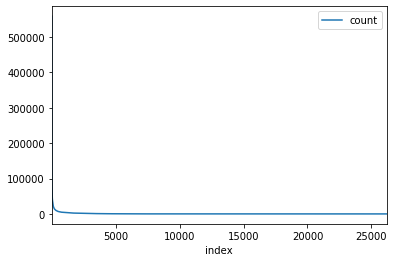

In [12]:
anchor_list.plot(x='index', y='count')

# 数据处理，可以先不做，看看采样函数的作用再调

In [13]:
anchor_list

,index,live_uid,count
0,1,730183576,558593
1,2,16673072,123029
2,3,4994793,95888
3,4,21678553,94230
4,5,735415548,90641
...,...,...,...
26190,26191,7519946,1
26191,26192,45927808,1
26192,26193,700122389,1
26193,26194,34400945,1


In [46]:
frequent_anchor = anchor_list[anchor_list['count']>=10]

In [41]:
len(anchor_list)

26195

# 定义采样函数

In [79]:
def item2vec_sampling(data, vocabulary_size,
            negative_samples=1., shuffle=True,
            categorical=False, sampling_table=None, seed=None):
    """
    data: List[List[Int]]
    vocabulary_size: number of all anchors
    negative_samples: number of negative samples / number of positive samples
    shuffle: whether to shuffle the return value
    categorical: whether to use one-hot label or binary label
    sampling_table: whether to use a sampling table to down sample frequent anchors and over sample infrequent ones
    seed: whether to use a fixed random seed
    returns: a list of instance pairs and a list of labels
    """
    couples = []
    labels = []
    couples_append = couples.append
    labels_append = labels.append

    for sequence in data:
        if len(sequence) <= 1:
            continue
            
        for wi in sequence:
            if not wi:
                continue
            if sampling_table is not None:
                if sampling_table[wi] < random.random():
                    continue

            for wj in sequence:
                if wj != wi:
                    if not wj:
                        continue
                    couples_append([wi, wj])
                    if categorical:
                        labels_append([0, 1])
                    else:
                        labels_append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                     random.randint(1, vocabulary_size)]
                    for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)

    return couples, labels

# 定义live_uid到index和index到live_uid的映射

In [47]:
index2uid = dict([(i, uid) for i, uid in zip(frequent_anchor['index'], frequent_anchor['live_uid'])])

In [48]:
uid2index = dict([(uid, i) for uid, i in zip(frequent_anchor['live_uid'], frequent_anchor['index'])])

# 将观看数据处理成Iterable[Iterable[Int]]的格式

In [49]:
view_data['index'] = view_data['live_uid'].map(uid2index)

In [50]:
view_data

,uid,live_uid,index
0,159876050,724698357,7471.0
1,735586379,724698357,7471.0
2,735586379,724698357,7471.0
3,108339673,724698357,7471.0
4,108339673,724698357,7471.0
...,...,...,...
18928319,722748450,14237047,NaN
18928320,99570557,733632108,8719.0
18928321,134628369,733632108,8719.0
18928322,735200625,735587024,4197.0


In [51]:
view_data.dropna()

,uid,live_uid,index
0,159876050,724698357,7471.0
1,735586379,724698357,7471.0
2,735586379,724698357,7471.0
3,108339673,724698357,7471.0
4,108339673,724698357,7471.0
...,...,...,...
18928318,80080259,287009768,5403.0
18928320,99570557,733632108,8719.0
18928321,134628369,733632108,8719.0
18928322,735200625,735587024,4197.0


In [53]:
data = {}
for uid, index in view_data[['uid', 'index']].dropna().values:
    if uid not in data:
        data[uid] = set()
    data[uid].add(int(index))

# 采样

In [55]:
V = len(index2uid)

In [57]:
sampling_table = keras.preprocessing.sequence.make_sampling_table(V + 1)

In [60]:
len(sampling_table)

15471

In [59]:
len(sampling_table[sampling_table==1])

5274

In [ ]:
couples, labels = item2vec_sampling(data.values(), V, sampling_table=sampling_table, shuffle=False)